In [1]:
import torch
import torchvision as tv
from PIL import Image
import numpy as np

In [2]:
import requests
from io import BytesIO
import matplotlib.pyplot as plt

In [3]:
# Check for device

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
if torch.cuda.is_available():
    print('GPU is available')
    
else:
    print('Running on CPU. Be very patient')

cuda:0
GPU is available


In [4]:
# Import the model
vgg = tv.models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad = False

# Transfer to the device
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [5]:
# Function for loading the images

def image_loader(path,max_size =512,shape = None):
    if('http' in path):
        response = requests.get(path)
        img = Image.open(BytesIO(response.content))
        img = img.convert('RGB')
    else:
        img = Image.open(path).convert('RGB')
        
    if(max(img.size)>max_size):
        size = max_size
        
    else:
        size = img.size
    
    if shape is not None:
        size = shape
        
    
    im_transform = tv.transforms.Compose([tv.transforms.Resize(size),
                                          tv.transforms.ToTensor(),
                                          tv.transforms.Normalize((0.485, 0.456, 0.406), 
                                                                  (0.229, 0.224, 0.225))])
        
    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    img = im_transform(img)[:3,:,:].unsqueeze(0)
    
    return img

In [6]:
content_image = image_loader('picasso1.jpg').to(device)
style_image = image_loader('picasso_pic.jpg',shape = content_image.shape[-2:]).to(device)

In [7]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

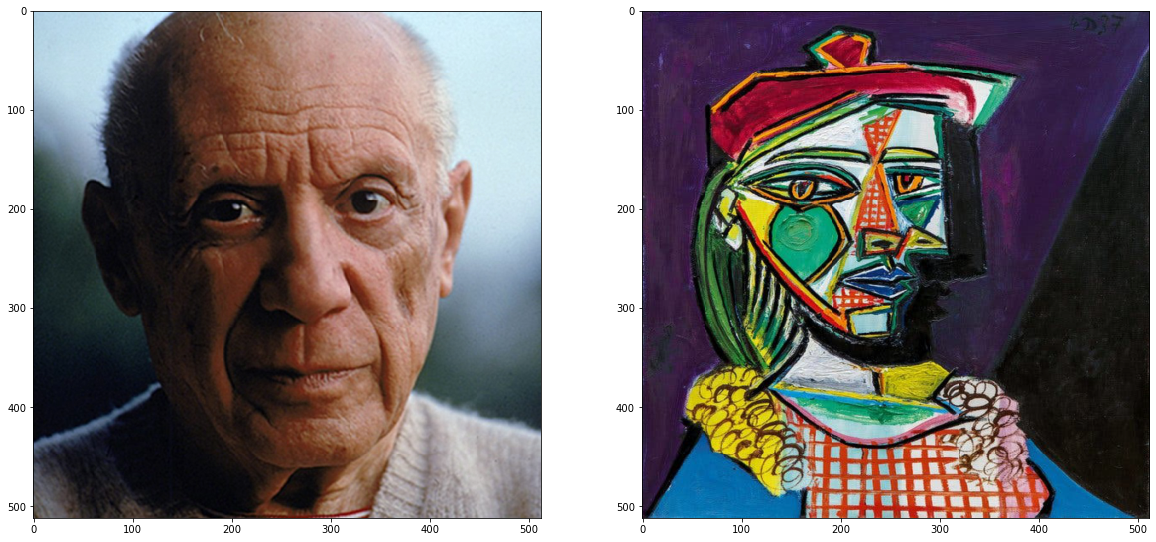

In [8]:
#display the pics

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(im_convert(content_image))
ax2.imshow(im_convert(style_image))

In [9]:
def get_features(model,layers,image):
    
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

The style loss is calculated as the squared difference between the **gram matrixes** of the target and style image at the desired layers. 

In [10]:
def gram_matrix(tensor):
    _,d,h,w = tensor.size()
    matrix1 = tensor.view(d,h*w)
    matrix2 = matrix1.t()
    gram = torch.mm(matrix1,matrix2)
    return gram

In [11]:
# Define the layers to fetch the features and content from:

# This is specific to VGG19

layers = {'0': 'conv1_1',
          '5': 'conv2_1',                 
          '10': 'conv3_1',                 
          '19': 'conv4_1',                 
          '21': 'conv4_2',  ## content representation                 
          '28': 'conv5_1'
         }

In [12]:
style_features = get_features(vgg,layers,style_image)
content_features = get_features(vgg,layers,content_image)

In [13]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content_image.clone().requires_grad_(True).to(device)

In [14]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e9  # beta

In [15]:
# define the optimizer
optimizer = torch.optim.Adam([target])

Total loss:150402688.0 at iteration:500


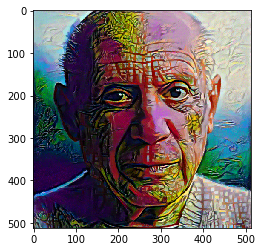

Total loss:126392240.0 at iteration:1000


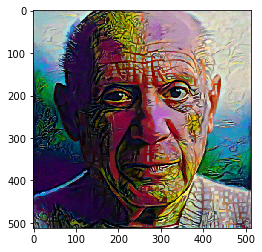

Total loss:107262000.0 at iteration:1500


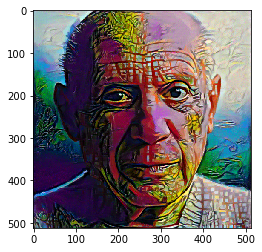

Total loss:91491632.0 at iteration:2000


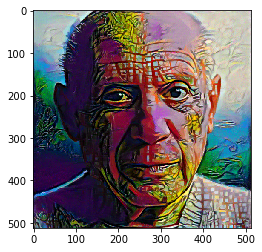

Total loss:78436088.0 at iteration:2500


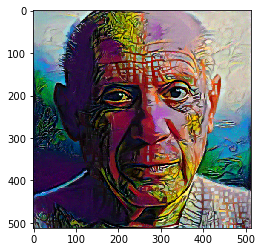

Total loss:67518776.0 at iteration:3000


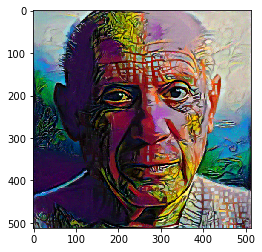

Total loss:58422448.0 at iteration:3500


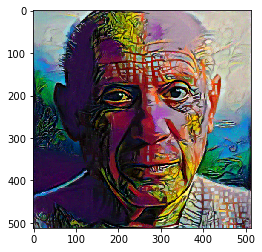

Total loss:50905784.0 at iteration:4000


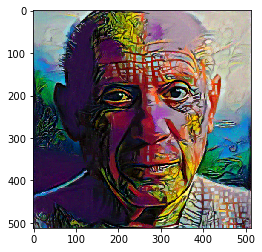

Total loss:44495696.0 at iteration:4500


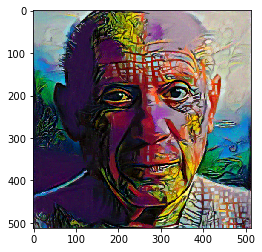

Total loss:39014144.0 at iteration:5000


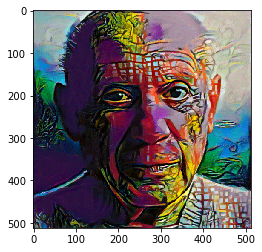

Total loss:34332912.0 at iteration:5500


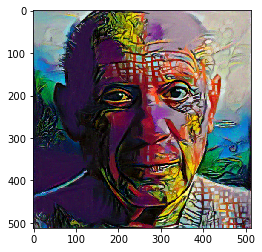

Total loss:30440910.0 at iteration:6000


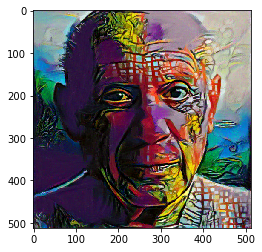

Total loss:27265854.0 at iteration:6500


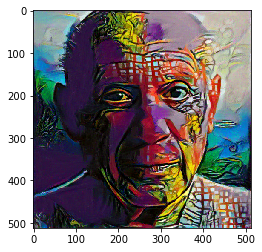

Total loss:24713244.0 at iteration:7000


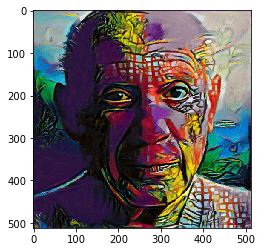

Total loss:22672582.0 at iteration:7500


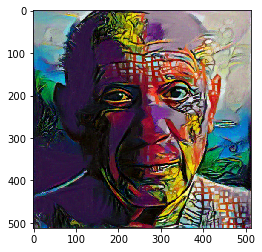

Total loss:21026034.0 at iteration:8000


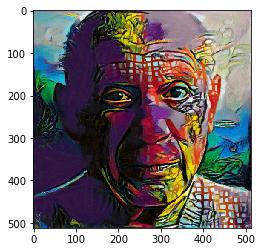

In [19]:
epoch = 8000
print_every = 500

for i in range(1,epoch+1):
    optimizer.zero_grad()
    target_features = get_features(vgg,layers,target)
    content_loss = torch.mean((target_features['conv4_2']-content_features['conv4_2'])**2)
    
    style_loss =0
    for layer in style_weights:
        temp_target_feature = target_features[layer]
        target_gram = gram_matrix(temp_target_feature)
        _, d, h, w = temp_target_feature.shape
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
    loss = content_weight * content_loss + style_weight * style_loss
    
    loss.backward()
    
    optimizer.step()
    
    if (i%print_every ==0):
        print('Total loss:{} at iteration:{}'.format(loss.item(),i))
        plt.imshow(im_convert(target))
        plt.show()

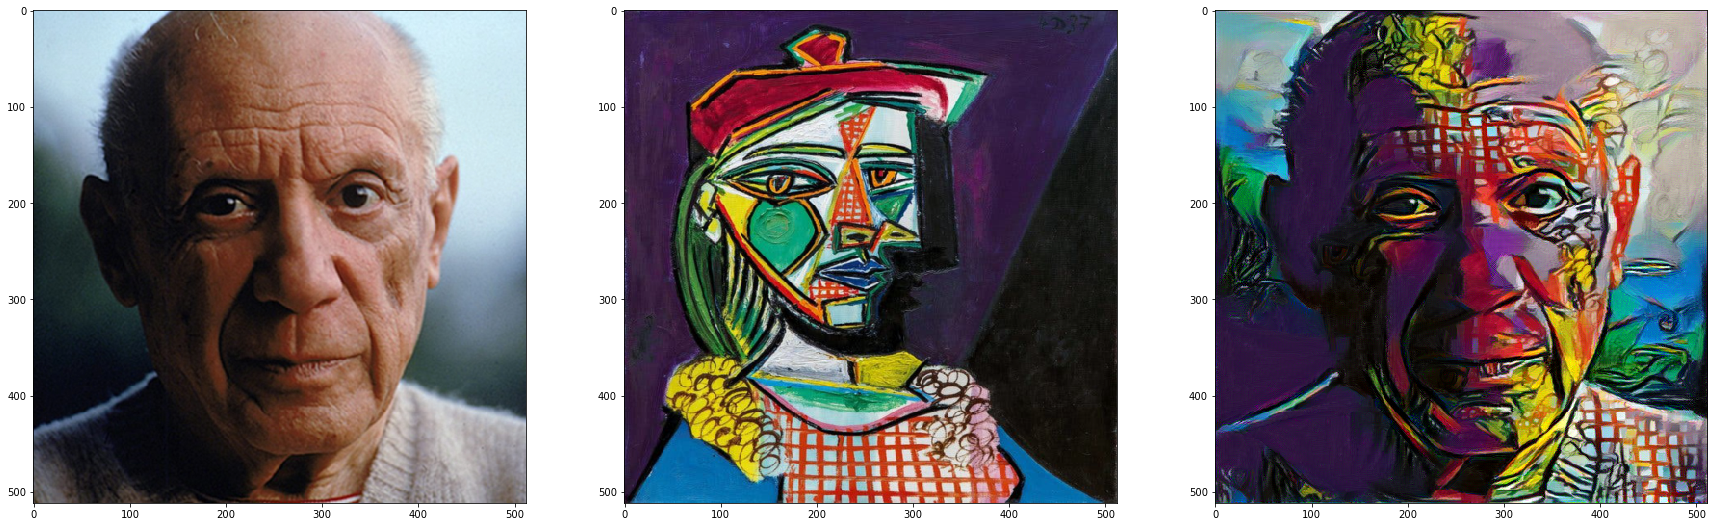

In [20]:
# display content and final, target image
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(30, 20))
ax1.imshow(im_convert(content_image))
ax2.imshow(im_convert(style_image))
ax3.imshow(im_convert(target))